# Survival Analysis Tutorial with R

SEOYEON CHOI  
2023-06-01

## Import

In [4]:
library(survival)
library(survminer)
library(epitools)

library(tidyverse)
library(ggplot2)

# Odds Ratio

In [5]:
head(lung) # survival package에 있는 lung 데이터 사용

## 독립변수가 범주형변수일때

ref : (odds ratio\](https://en.wikipedia.org/wiki/Odds_ratio)

A의 성공 확률 = $\frac{P(A)}{1-P(A)}$

B의 성공 확률 = $\frac{P(B)}{1-P(B)}$

Odds Ratio = A의 성공 확률 / B의 성공 확률

= $\frac{\frac{P(A)}{1-P(A)}}{\frac{P(B)}{1-P(B)}}$

해석

-   1보다 클 경우
    -   A집단의 성공할 확률이 B 집단이 성공할 확률보다 높다.
-   1보다 작을 경우
    -   A집단의 성공할 확률이 B 집단이 성공할 확률보다 낮다.
-   1일 경우
    -   A집단의 성공할 확률이 B 집단이 성공할 확률보다 같다.

> **Tip**
>
> 어떤 확률을 기준으로 하느냐에 따라 해석은 달라진다.
>
> ex) 어떤 검사 값이 정상이 나올 확률
>
> -   1보다 클 경우
>     -   A집단의 정상일 확률이 B 집단이 정상일 확률보다 높다.
> -   1보다 작을 경우
>     -   A집단의 정상일 확률이 B 집단이 정상일 확률보다 낮다.
> -   1일 경우
>     -   A집단의 정상일 확률이 B 집단이 정상일 확률보다 같다.

In [43]:
tmp <- lung %>% mutate(tmp = ifelse(ph.karno < 70, 1, 0));head(tmp)

In [7]:
tmp %>% select(sex, tmp) %>% table()

   tmp
sex   0   1
  1 122  15
  2  80  10

위의 표에서 tmp 가 0인 것이 성공, 1인 것이 실패로 보고, A집단이 성별 =
1, B집단이 성별 = 2로 본다면 오즈비는 아래와 같이 계산된다.

In [8]:
# A의 성공 확률
(122/137)/(15/137)
# = (122/137)/((137-122)/137)

8.13333333333333

In [9]:
# B의 성공 확률
(80/90)/(10/90)
# = (80/90)/((80-10)/90)

8

In [10]:
# 오즈비
((122/137)/(15/137))/((80/90)/(10/90))

1.01666666666667

In [11]:
rst <- oddsratio.wald(tmp %>% select(sex, tmp) %>% table())
rst

$correction 
 FALSE

In [12]:
rst$data

In [13]:
rst$measure # Odds Ratio

1보다 크게 나왔으니까 sex=1인 집단이 성공할 활률이 sex=2인 집단이 성공할
확률보다 높다.

In [14]:
rst$p.value # fisher or chi-square test result

p값이 0.05보다 높게 나와 오즈비가 유의하지 않다는 것을 알 수 있다.

In [15]:
rst$correction # correction 

FALSE

## 독립변수가 연속형변수일때

독립변수를 연속형 변수로, 종속변수를 이산형(0 또는 1)`binomial`으로
지정한 일반화 선형 모형을 사용할 것이다.

> **Tip**
>
> 물론 아래 방식은 독립변수가 범주형 변수일때도 사용 가능하다.
>
> 하지만 독립변수가 연속형 변수일때 독립변수가 범주형일때 사용한
> 방법으로는 사용이 불가능하다.

In [16]:
model <- glm(tmp ~ wt.loss, data = tmp, family = binomial)
summary(model)


Call:
glm(formula = tmp ~ wt.loss, family = binomial, data = tmp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5488  -0.4825  -0.4708  -0.4651   2.1864  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.169588   0.279940  -7.750 9.18e-15 ***
wt.loss      0.005184   0.016325   0.318    0.751    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 146.04  on 213  degrees of freedom
Residual deviance: 145.94  on 212  degrees of freedom
  (14 observations deleted due to missingness)
AIC: 149.94

Number of Fisher Scoring iterations: 4

In [17]:
odds_ratio <- exp(coef(model))[[2]] # 오즈비
ci_lower <- exp(confint(model))[2,][1] # 95% 신뢰구간 하한
ci_upper <- exp(confint(model))[2,][2] # 95% 신뢰구간 상한
list(odds_ratio=odds_ratio,ci_lower=ci_lower,ci_upper=ci_upper)

Waiting for profiling to be done...

Waiting for profiling to be done...


$odds_ratio 
 1.00519779379364 
 $ci_lower 
 2.5 %: 0.971395088673715 
 $ci_upper 
 97.5 %: 1.03624397215135

## Odds Ratio Plot

Data Ref:
[stackoverflow](https://stackoverflow.com/questions/47085514/simple-way-to-visualise-odds-ratios-in-r)

and Odds plot code made by me

In [44]:
boxLabels = c("Package recommendation", "Breeder’s recommendations", "Vet’s 
recommendation", "Measuring cup", "Weigh on scales", "Certain number of 
cans", "Ad lib feeding", "Adjusted for body weight")

In [47]:
df <- data.frame(yAxis = length(boxLabels):1, 
                 boxOdds = log(c(0.9410685, 
                                 0.6121181, 1.1232907, 1.2222137, 0.4712629, 0.9376822, 1.0010816, 
                                 0.7121452)), 
                 boxCILow = c(-0.1789719, -0.8468693,-0.00109809, 0.09021224,
                              -1.0183040, -0.2014975, -0.1001832,-0.4695449), 
                 boxCIHigh = c(0.05633076, -0.1566818, 0.2326694, 0.3104405, 
                               -0.4999281, 0.07093752, 0.1018351, -0.2113544))

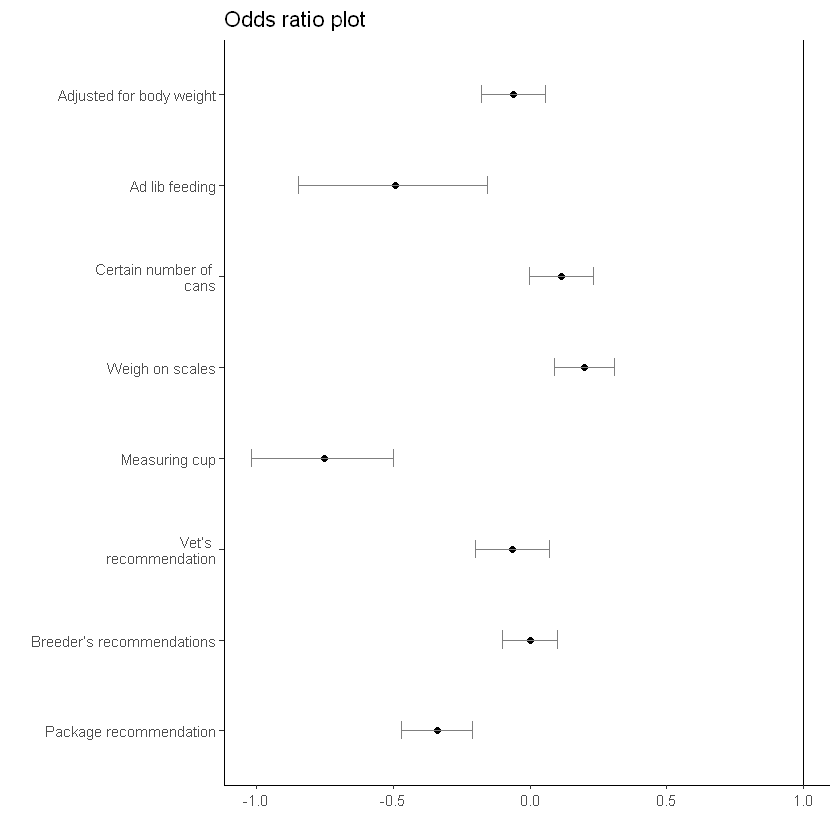

In [48]:
ggplot(data = df,
       mapping = aes(y = forcats::fct_rev(f = forcats::fct_inorder(f = boxLabels)))) +
  geom_point(aes(x = boxOdds),size = 1.5, color = "black")+
  geom_errorbarh(aes(xmax = boxCIHigh, xmin = boxCILow), size = .5, height = .2, color = "gray50") +
  theme_classic()+
  geom_vline(xintercept = 1) + # 오즈비는 1을 기준으로 보기 때문에 1의 수직선을 그려줘야 한다.
  theme(panel.grid.minor = element_blank()) +
  labs(x = "",  y = "", title = "Odds ratio plot") + 
  scale_y_discrete(labels = boxLabels)

``` r
# the method of save ggplot file
# You can allocate path
ggsave(file= paste0(path,"name.png", sep=''), width=15, height=8, units = c("cm"))
```

# Hazard Ratio

In [20]:
head(ovarian) # survival 패키지에 내장된 데이터 사용

데이터 설명

-   futime: survival or censoring time
-   fustat: censoring status
-   age: in years
-   resid.ds: residual disease present (1=no,2=yes)
-   rx: treatment group
-   ecog.ps: ECOG performance status (1 is better, see reference)

간단한 모형 설정

-   Surv()에 시간 `time`과 사건 `event`를 지정해주고 다변량 변수로서
    rx와 age를 지정해주었다.

In [22]:
summary(coxph(Surv(time = futime, event = fustat) ~ as.factor(rx) + age, data=ovarian))

Call:
coxph(formula = Surv(time = futime, event = fustat) ~ as.factor(rx) + 
    age, data = ovarian)

  n= 26, number of events= 12 

                   coef exp(coef) se(coef)      z Pr(>|z|)   
as.factor(rx)2 -0.80397   0.44755  0.63205 -1.272  0.20337   
age             0.14733   1.15873  0.04615  3.193  0.00141 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
as.factor(rx)2    0.4475      2.234    0.1297     1.545
age               1.1587      0.863    1.0585     1.268

Concordance= 0.798  (se = 0.076 )
Likelihood ratio test= 15.89  on 2 df,   p=4e-04
Wald test            = 13.47  on 2 df,   p=0.001
Score (logrank) test = 18.56  on 2 df,   p=9e-05

> **Note**
>
> `as.factor`는 R에서 R의 변수로서 인식하도록 변환해준 것이라 보면 된다.

### 단변량을 여러개 한 번에 보고 싶을때

> **Note**
>
> 물론 다변량으로 확장 가능한 코드이다.

In [23]:
cova <- c("resid.ds","rx","age") # 보고 싶은 단변량 변수명을 입력한다.

In [24]:
univ <- lapply(cova, function(x) as.formula(paste('Surv(time = futime, event = fustat)~', x)))
univ
# 아래의 리스트를 생성
# Surv(time = futime, event = fustat) ~ resid.ds
# Surv(time = futime, event = fustat) ~ rx
# Surv(time = futime, event = fustat) ~ age

[[1]]
Surv(time = futime, event = fustat) ~ resid.ds
<environment: 0x000000002f8ff350>

[[2]]
Surv(time = futime, event = fustat) ~ rx
<environment: 0x000000002f9020f0>

[[3]]
Surv(time = futime, event = fustat) ~ age
<environment: 0x000000002519fd00>

> **Tip**
>
> `lapply`
>
> -   리스트 또는 벡터와 같은 객체에 함수를 적용하는 데 사용

In [25]:
univ_rst <- lapply(univ, function(x) {
  model <- coxph(x, data = ovarian)
  summary <- summary(model)
  HR <- summary$coef[2]  # Hazard ratio
  CI_lower <- summary$conf.int[,"lower .95"]  # Lower bound of confidence interval
  CI_upper <- summary$conf.int[,"upper .95"]  # Upper bound of confidence interval
  p_value <- summary$wald["pvalue"]  # P-value
  tab <- c(HR, CI_lower, CI_upper)
  names(tab) <- c("HR", "lower", "upper")
  return(tab)
})

콕스 비례 모형

-   생존 분석에서 쓰이는 통계 모형
-   준모수적 방법 이용하여 생존함수 추정
-   기본 가정: 비례위험은 시간에 상관없이 어떤 변수의 위험비가 항상
    일정하다.

ref: [콕스 비례
모형](https://ko.wikipedia.org/wiki/%EB%B9%84%EB%A1%80%EC%9C%84%ED%97%98%EB%AA%A8%ED%98%95)

In [26]:
univ_rst # 리스트별로 Hazard Rtio, 95% 신뢰구간을 구했다.

HR 3.35070358052788 lower 0.896998922171813 upper 12.5164191472818 
 
 HR 0.550801907277936 lower 0.17432073353539 upper 1.74037095248581 
 
 HR 1.17541333170913 lower 1.0662320711259 upper 1.29577466085843

In [27]:
tab <- data.frame(t(data.frame(univ_rst, check.names = FALSE)))
# check.names = FALSE는 유효한 변수명인지 확인하지 말라는 옵션, 기본은 TRUE다.
tab

## Hazard Ratio Plot

In [28]:
df <- data.frame(yAxis = length(cova):1, # 그래프에 그려지는 변수의 순서를 지정해주기 위함
                 boxhz = tab$HR,
                 boxCILow = tab$lower,
                 boxCIHigh = tab$upper)

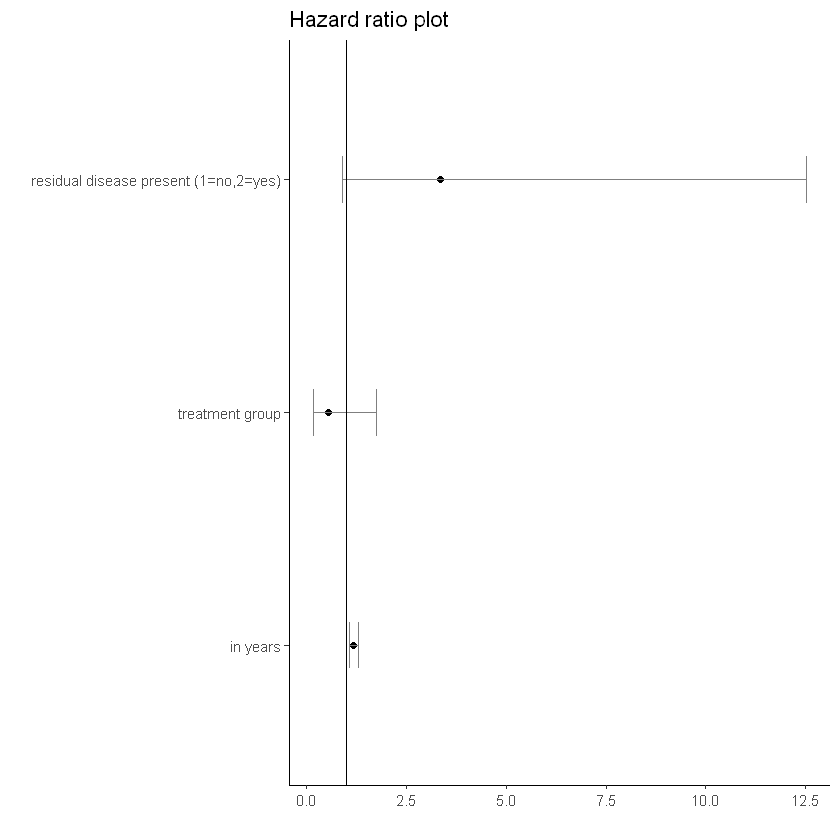

In [29]:
ggplot(data = df,
       mapping = aes(y = forcats::fct_rev(f = forcats::fct_inorder(f = cova)))) +
  geom_point(aes(x = boxhz), size = 1.5, color = "black")+
  geom_errorbarh(aes(xmax = boxCIHigh, xmin = boxCILow), size = .5, height = .2, color = "gray50") +
  theme_classic()+
  geom_vline(xintercept = 1) +
  theme(panel.grid.minor = element_blank()) +
  labs(x = "",  y = "", title = "Hazard ratio plot")  +
  scale_y_discrete(labels = rev(c('residual disease present (1=no,2=yes)',
                                  'treatment group',
                                  'in years')))

# Survival Analysis

카플란-마이어 생존분석

-   시간에 따른 생존 비율 추정
-   비모수적 분석방법

In [30]:
Surv(time = lung$time, event = lung$status)

  [1]  306   455  1010+  210   883  1022+  310   361   218   166   170   654 
 [13]  728    71   567   144   613   707    61    88   301    81   624   371 
 [25]  394   520   574   118   390    12   473    26   533   107    53   122 
 [37]  814   965+   93   731   460   153   433   145   583    95   303   519 
 [49]  643   765   735   189    53   246   689    65     5   132   687   345 
 [61]  444   223   175    60   163    65   208   821+  428   230   840+  305 
 [73]   11   132   226   426   705   363    11   176   791    95   196+  167 
 [85]  806+  284   641   147   740+  163   655   239    88   245   588+   30 
 [97]  179   310   477   166   559+  450   364   107   177   156   529+   11 
[109]  429   351    15   181   283   201   524    13   212   524   288   363 
[121]  442   199   550    54   558   207    92    60   551+  543+  293   202 
[133]  353   511+  267   511+  371   387   457   337   201   404+  222    62 
[145]  458+  356+  353   163    31   340   229   444+  315+  182

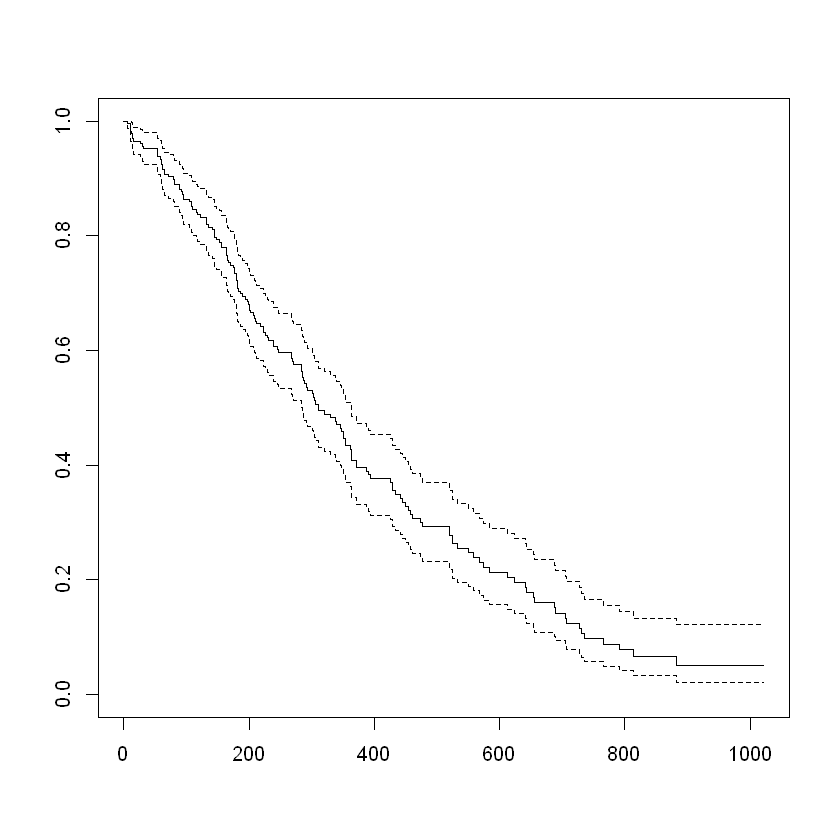

In [31]:
plot(Surv(time = lung$time, event = lung$status))

## Log-Rank Test

-   카플란-마이어 생존분석에서 나온 생존 함수가 유의하게 다른지 검정하는
    방법
-   서로 다른 두 집단의 생존률(사건 발생률)을 비교하는 비모수적 가설
    검정법
-   `survdiff`는 집단 간의 생존함수를 비교하기 위해 사용
-   p값이 0.05보다 작을 경우 생존 곡선 간에 차이가 있는 것으로 본다.

In [32]:
survdiff(Surv(time = time, event = status) ~ sex, data=lung) # lung 데이터에서 성별에 따른 생존곡선 차이 비교

Call:
survdiff(formula = Surv(time = time, event = status) ~ sex, data = lung)

        N Observed Expected (O-E)^2/E (O-E)^2/V
sex=1 138      112     91.6      4.55      10.3
sex=2  90       53     73.4      5.68      10.3

 Chisq= 10.3  on 1 degrees of freedom, p= 0.001 

p 값이 0.0001로 나와 생존 곡선 간에 차이가 있다는 것을 알 수 있다.

## Survival plot

Ref : [ggkm](https://gist.github.com/araastat/9927677)

In [33]:
ggkm <- function(sfit, returns = FALSE,
xlabs = "Time", ylabs = "survival probability",
ystratalabs = NULL, ystrataname = NULL,
timeby = 100, main = "Kaplan-Meier Plot",
pval = TRUE, ...) {
require(plyr)
require(ggplot2)
require(survival)
require(gridExtra)
if(is.null(ystratalabs)) {
   ystratalabs <- as.character(levels(summary(sfit)$strata))
}
m <- max(nchar(ystratalabs))
if(is.null(ystrataname)) ystrataname <- "Strata"
times <- seq(0, max(sfit$time), by = timeby)
.df <- data.frame(time = sfit$time, n.risk = sfit$n.risk,
    n.event = sfit$n.event, surv = sfit$surv, strata = summary(sfit, censored = T)$strata,
    upper = sfit$upper, lower = sfit$lower)
levels(.df$strata) <- ystratalabs
zeros <- data.frame(time = 0, surv = 1, strata = factor(ystratalabs, levels=levels(.df$strata)),
    upper = 1, lower = 1)
.df <- rbind.fill(zeros, .df)
d <- length(levels(.df$strata))
p <- ggplot(.df, aes(time, surv, group = strata)) +
    geom_step(aes(linetype = strata), size = 0.7) +
    theme_bw() +
    theme(axis.title.x = element_text(vjust = 0.5)) +
    scale_x_continuous(xlabs, breaks = times, limits = c(0, max(sfit$time))) +
    scale_y_continuous(ylabs, limits = c(0, 1)) +
    theme(panel.grid.minor = element_blank()) +
    theme(legend.position = c(ifelse(m < 10, .28, .35), ifelse(d < 4, .25, .35))) +
    theme(legend.key = element_rect(colour = NA)) +
    labs(linetype = ystrataname) +
    theme(plot.margin = unit(c(0, 1, .5, ifelse(m < 10, 1.5, 2.5)), "lines")) +
    ggtitle(main)
 
if(pval) {
    sdiff <- survdiff(eval(sfit$call$formula), data = eval(sfit$call$data))
    pval <- pchisq(sdiff$chisq, length(sdiff$n)-1, lower.tail = FALSE)
    pvaltxt <- ifelse(pval < 0.0001, "p < 0.0001", paste("p =", sprintf("%.4f", pval) ))
    p <- p + annotate("text", x = 0.6 * max(sfit$time), y = 0.1, label = pvaltxt)
}
## Plotting the graphs
    print(p)
    if(returns) return(p)
   
}

사용법

In [34]:
labs=paste("성별",c("Male","Female"))  # legend 항목 지정 test-ref 순
strataname=paste("Sex") # legend 명 지정

In [35]:
lung$temp=ifelse(lung$sex==2,0,1) # Ref 지정, Ref=0, Test-Ref 순으로 그래프가 그려짐
# 여기서는 여성(sex=2)를 ref로 지정해주었다.

> **Note**
>
> 변수에 ref가 지정되지 않으면 결과 해석에 혼동이 있을 수 있으니 ref
> 지정이 필요

In [36]:
fit=survfit(Surv(time = time, event = status)~temp ,data=lung)

fit

Call: survfit(formula = Surv(time = time, event = status) ~ temp, data = lung)

         n events median 0.95LCL 0.95UCL
temp=0  90     53    426     348     550
temp=1 138    112    270     212     310

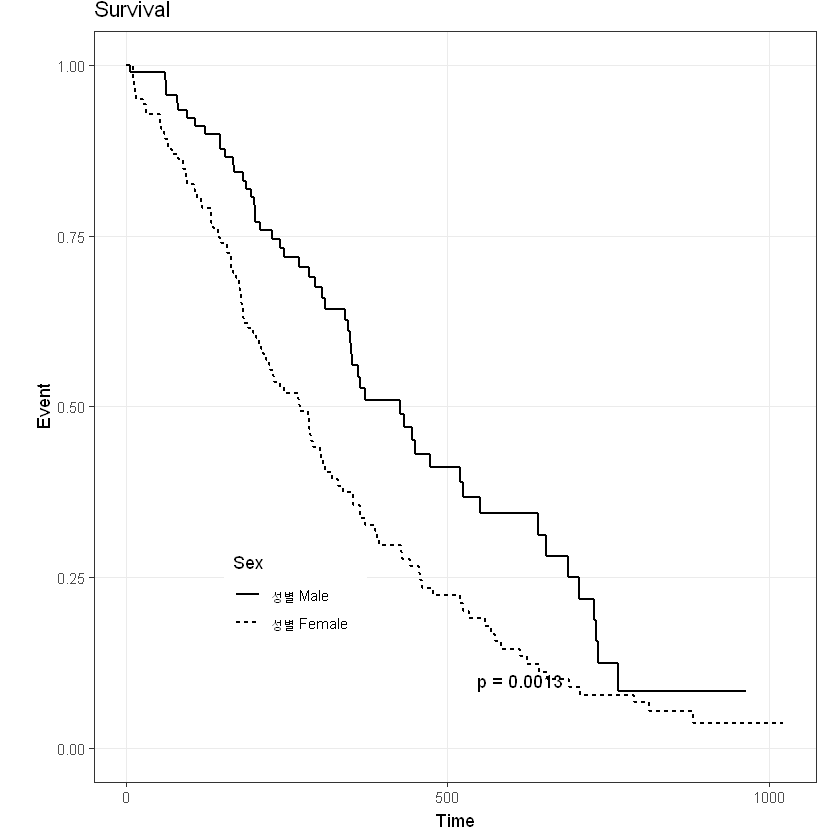

In [39]:
ggkm(fit,timeby=500,ystratalabs=labs,ystrataname=strataname, main = 'Survival', ylab='Event')

> **Warning**
>
> 여러개 그룹에 대하여 생존 분석을 시행하고자 할때 log rank test 해석에
> 주의하여야 한다.
>
> 해당 결과에 대한 대립가설은 그룹 중 하나라도 다른 생존곡선이
> 존재한다라는 의미가 되기 때문에 각 집단별로 비교해보고 차이가 유의한
> 그룹들을 찾는 것이 낫다.

참고로, 아래와 같이 `summary` 해주면 단변량의 항목별로 시간별로 볼 수
있다.

또한, 가장 마지막 값 저장하기 위해 아래 코드 사용 가능

``` r
sink('summary.txt')
summary(fit) 
sink()
```

In [40]:
summary(fit)

Call: survfit(formula = Surv(time = time, event = status) ~ temp, data = lung)

                temp=0 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    5     90       1   0.9889  0.0110       0.9675        1.000
   60     89       1   0.9778  0.0155       0.9478        1.000
   61     88       1   0.9667  0.0189       0.9303        1.000
   62     87       1   0.9556  0.0217       0.9139        0.999
   79     86       1   0.9444  0.0241       0.8983        0.993
   81     85       1   0.9333  0.0263       0.8832        0.986
   95     83       1   0.9221  0.0283       0.8683        0.979
  107     81       1   0.9107  0.0301       0.8535        0.972
  122     80       1   0.8993  0.0318       0.8390        0.964
  145     79       2   0.8766  0.0349       0.8108        0.948
  153     77       1   0.8652  0.0362       0.7970        0.939
  166     76       1   0.8538  0.0375       0.7834        0.931
  167     75       1   0.8424  0.0387       0.7699        0.922


# Appendix

-   아래는 오즈비(Odds Ratio), 위험비(Hazard Ratio), 생존분석(Survival
    Analysis) 함수 구현한 것이다. 반복 사용할때 유용하겠지!

-   p값 정리 function

In [50]:
pfunc<- function(p_value){
  if (p_value <= 0.0001) {
    print("<.0001")
  } else if (p_value >= 1) {
    print(">.9999")
  }
  else {
    print(sprintf("%.4f", p_value))
  }
}

사용법

In [51]:
pfunc(0)

[1] "<.0001"

In [52]:
pfunc(0.0001)

[1] "<.0001"

In [53]:
pfunc(0.3164889)

[1] "0.3165"

In [54]:
pfunc(1.5)

[1] ">.9999"

-   오즈비 function 범주형일 때

In [55]:
oddsfunc <- function(model){
  odds_ratio <- round(exp(coef(model)),2)[2]
  confint_odds_ratio <- exp(confint(model))
  confint_odds_ratio <- round(data.frame(lower = confint_odds_ratio[, 1], upper = confint_odds_ratio[, 2])[2,],2)
  odds <- paste(odds_ratio[1],'(',confint_odds_ratio[1],'-',confint_odds_ratio[2],')')
  return(odds)
}


chis_fisher_test <- function(df, cond1, cond2){
  tst <- matrix(c(df %>% filter(cond1 == 1 & cond2 == 1) %>% nrow(),
                  df %>% filter(cond1 == 1 & cond2 == 0) %>% nrow(),
                  df %>% filter(cond1 == 0 & cond2 == 1) %>% nrow(),
                  df %>% filter(cond1 == 0 & cond2 == 0) %>% nrow()),
                ncol=2)
  per <- matrix(round((tst[,1]/(tst[,1]+tst[,2]))*100,0),ncol=1)
  if (min(tst) < 5) {
    chi <- pfunc(round(fisher.test(tst)$p.value,4))
  } else {
    chi <- pfunc(round(chisq.test(tst)$p.value,4))
  }
  
  model <- glm(cond1 ~ cond2, data = df, family = binomial)
  list(test = tst, sum = rbind(sum(tst[1,]),sum(tst[2,])), 
       per = per, p_value = rbind(chi,''),
       oddsratio = rbind(oddsfunc(model),''))
}

사용법

In [57]:
tmp_1 <- lung %>% mutate(tmp01 = ifelse(ph.karno < 70, 1, 0),
                       tmp02 = ifelse(status == 1, 1, 0));head(tmp_1)

일단 범주형으로 만들어 주고(있으면 안 만들어도 되겠지)

In [58]:
chis_fisher_test(tmp_1,tmp_1$tmp01,tmp_1$tmp02)

[1] "0.2361"

Waiting for profiling to be done...


-   Survival Analysis 전체 생존 기간에 대하여 볼때, 변수 별도 보지 않고
    event랑 time만 볼때

In [59]:
surv_func <- function(df, date_col, event_col){
  df_temp <- df[complete.cases(df[, c(date_col, event_col)]), ]
  date_temp <- df_temp[, date_col] / 365.25
  surv_temp <- Surv(time = date_temp, event = as.numeric(df_temp[, event_col]))
  result1_temp<-coxph(surv_temp~1, data=df_temp)
  result2_temp <- summary(survfit(surv_temp ~ 1, data = df_temp))
  summary(result1_temp)
  list(cbind(round(result2_temp$surv[length(result2_temp$surv)],3),
             paste('(',round(result2_temp$lower[length(result2_temp$lower)],3),'-',
                   round(result2_temp$upper[length(result2_temp$upper)],3),')')),"cox"=result1_temp)
}

사용법

In [60]:
surv_func(tmp_1,"time","status")

[[1]]
     [,1]   [,2]               
[1,] "0.05" "( 0.021 - 0.123 )"

$cox
Call:  coxph(formula = surv_temp ~ 1, data = df_temp)

Null model
  log likelihood= -749.9098 
  n= 228 

-   Survival Analysis 단변량(다변량 확장 가능)에 대해 Survival
    probability와 95% 신뢰구간, Log rank Test 수행

In [61]:
surv_func_each <- function(df, date_col, event_col, cova_col) {
  df_temp <- df[complete.cases(df[, c(date_col, event_col, cova_col)]), ]
  date_temp <- df_temp[, date_col] / 365.25
  surv_temp <- Surv(time = date_temp, event = as.numeric(df_temp[, event_col]))
  coxph_fit <- coxph(as.formula(paste("surv_temp ~", cova_col)), data = df_temp)
  result_temp <- summary(survfit(surv_temp ~ df_temp[, cova_col], data = df_temp))
  # p_val <- pfunc(round(summary(coxph_fit)$coefficients[paste(cova_col), "Pr(>|z|)"],4))
  nor <- survdiff(surv_temp ~ df_temp[, cova_col], data = df_temp)
  nor_p <- pfunc(round((1 - pchisq(nor$chisq, length(nor$n) - 1)),4))
  list("surv" = result_temp, "nor_p" = nor_p,"coxph_fit"=coxph_fit)
}

surv_log_p <-function(df,date_col,event_col,cova_col){
  
  df_temp <- surv_func_each(df,date_col,event_col,cova_col)
  filename <- paste(path4,cova_col,"_",".txt", sep='')
  
  sink(filename)
  print(df_temp$surv) #데이터 결과 txt로 저장
  sink()
  
  lines <- readLines(filename)
  index <- which(grepl( "  time n.risk n.event survival std.err lower 95% CI upper 95% CI", lines))
  line1 <- strsplit(lines[index - 3][2], "\\s+")[[1]]
  line2 <- strsplit(tail(lines, n = 2)[1], "\\s+")[[1]]
  out <- rbind(cbind(line2[5],paste('(',line2[7],'-',line2[8],')'),df_temp$nor_p),
               cbind(line1[5],paste('(',line1[7],'-',line1[8],')'),''))
  colnames(out) <- c("Survival","95% CI","Log rank test")
  list(data.frame(out), df_temp$coxph_fit, df_temp$nor_p)
}

사용법(저장하고 해야해서 문법 구현만)

``` r
surv_log_p(tmp_1,"time","status","tmp01")
```

-   만든 Survival plot

In [62]:
surv_figure <-function(df,df2){
  ggsurvplot(survfit(df2), data = df,
             title = labs(title=''),
             # risk.table =TRUE,
             # risk.table.fontsize = 3,
             tables.height=0.15,
             palette = c("black"),
             xlab = "Years",
             # ylab = name1,
             tables.theme = theme_cleantable(),
             fun = 'pct',
             conf.int = FALSE,
             break.x.by = 1,
             # surv.scale="percent",
             censor= FALSE,
             # xlim = c(0,13),
             font.title = c(9, "black"),
             font.x = c(9, "black"),
             font.y = c(9, "black"),
             font.tickslab = c(9, "plain", "black"),
             font.legend = c(9,"bold"),
             # legend = c(0.2, 0.4),
             legend.title = element_blank(),
             legend = "none")
  # return(ggsave(file= paste0(path,name2,".png", sep=''), width=15, height=8, units = c("cm")))
  # 위는 저장하는 거라 path 지정해서 저장하면 된다.
}

사용법

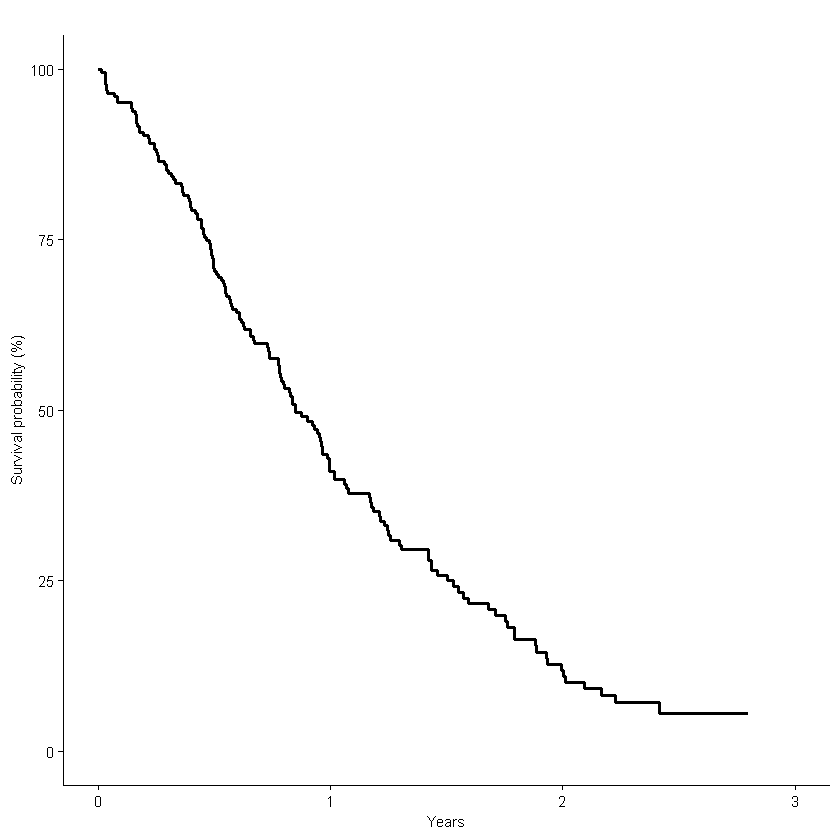

In [63]:
surv_figure(tmp,surv_func(tmp_1,"time","status")[[2]])

참고

In [64]:
surv_func(tmp_1,"time","status")[[2]]

Call:  coxph(formula = surv_temp ~ 1, data = df_temp)

Null model
  log likelihood= -749.9098 
  n= 228 